In [1]:
import flor
df = flor.utils.latest(flor.dataframe("page_text"))
df

,document,document_value,page,page_value,projid,tstamp,filename,page_text
0,1,RSCsmithV1.pdf,1,0,j6_parser,2025-09-16 08:01:37,doc_demux.py,DELIVERY BY HAND \nThe Honorable Merrick B. Ga...
1,1,RSCsmithV1.pdf,2,1,j6_parser,2025-09-16 08:01:37,doc_demux.py,"Attorney General Edward H. Levi, who assumed t..."
2,1,RSCsmithV1.pdf,3,2,j6_parser,2025-09-16 08:01:37,doc_demux.py,put: the Department of Justice's guiding manda...
3,1,RSCsmithV1.pdf,4,3,j6_parser,2025-09-16 08:01:37,doc_demux.py,charges against Mr. Trump. And to all who know...
4,1,RSCsmithV1.pdf,5,4,j6_parser,2025-09-16 08:01:37,doc_demux.py,FINAL REPORT ON THE SPECIAL COUNSEL'S \nINVEST...
...,...,...,...,...,...,...,...,...
169,1,RSCsmithV1.pdf,170,169,j6_parser,2025-09-16 08:01:37,doc_demux.py,"January 6, 2025 \nPage 12 \nwill greatly excee..."
170,1,RSCsmithV1.pdf,171,170,j6_parser,2025-09-16 08:01:37,doc_demux.py,
171,1,RSCsmithV1.pdf,172,171,j6_parser,2025-09-16 08:01:37,doc_demux.py,
172,1,RSCsmithV1.pdf,173,172,j6_parser,2025-09-16 08:01:37,doc_demux.py,DELIVERY BY HAND \nThe Honorable Merrick B. Ga...


In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from user_defined_functions import get_headings, get_page_numbers

In [ ]:
df["f_headings"] = df["page_text"].map(get_headings)
df

In [ ]:
df["f_page_nums"] = df["page_text"].map(get_page_numbers)
df

In [2]:
print(df.iloc[2]['page_text'])

put: the Department of Justice's guiding mandate, which my Office strove to uphold, is that power, 
politics, influence, status, wealth, fear, and favor should not impede justice under the law. 
When I assumed responsibility for the matters you assigned to me, I came to the work with 
no preconceived notion of what the just outcome of the investigations would be. I was not yet 
familiar with all of the relevant facts and had not yet researched the relevant law. Depending upon 
what the investigations revealed, I was equally comfortable closing the investigations or moving 
forward with prosecutions in one or both of the matters, having done both in high profile matters 
throughout my career. 
To make prosecutorial determinations, my Office gathered relevant evidence and examined 
whether that evidence established violations of federal criminal law. In doing so I was guided by 
the Principles of Federal Prosecution, a series of considerations designed to promote the fair and 
evenhanded

In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 85.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


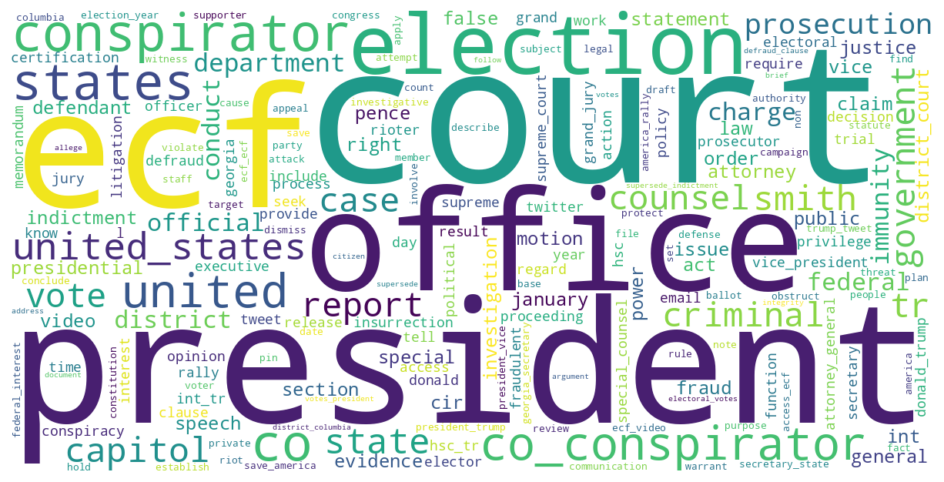

In [5]:
import spacy
from wordcloud import STOPWORDS

# 1) Documents: use each page as a separate document so min_df / max_df make sense
docs = df.page_text.tolist()

# 2) Setup spaCy and stopwords
nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat"])
extra_stops = set(STOPWORDS) | {"figure", "like", "use", "etc"}
spacy_stops = {w.lower() for w in nlp.Defaults.stop_words}
stops = extra_stops | spacy_stops

# 3) Lemma-based analyzer that now also yields bigrams
def lemma_analyzer(doc):
    tokens = []
    for t in nlp(doc):
        if not t.is_alpha:
            continue
        lemma = t.lemma_.lower()
        if lemma in stops:
            continue
        tokens.append(lemma)
    # unigrams
    for tok in tokens:
        yield tok
    # bigrams
    for w1, w2 in zip(tokens, tokens[1:]):
        yield f"{w1} {w2}"

# 4) TF–IDF over lemmas + bigrams (ngram_range removed because analyzer emits both)
from sklearn.feature_extraction.text import TfidfVectorizer
min_df_val = 2 if len(docs) >= 2 else 1
vec = TfidfVectorizer(
    analyzer=lemma_analyzer,
    max_features=5500,
    min_df=min_df_val,
    max_df=0.6 if len(docs) > 3 else 1.0
)
X = vec.fit_transform(docs)

# Aggregate TF-IDF scores across all documents (sum) for word cloud weights
weights_arr = X.sum(axis=0).A1
weights = dict(zip(vec.get_feature_names_out(), weights_arr))

# 5) Make bigrams render as single tokens in the cloud
weights_wc = {k.replace(" ", "_"): v for k, v in weights.items()}

# 6) Word cloud
from wordcloud import WordCloud  # already imported earlier, safe if not re-run
import matplotlib.pyplot as plt   # already imported earlier
wc = WordCloud(
    width=1200, height=600,
    background_color="white",
    collocations=False,
    stopwords=extra_stops,
    random_state=50
).generate_from_frequencies(weights_wc)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()